# ADSP Pheno Data Preprocessing

This notebook describes phenotype definition of ADSP samples if we need to exclude subjects based on 
* missing data for covariates, AD
* exclude controls under the age of 60
* recalculate PCA and check any outliers  

## Phenotype

In [3]:
library(tableone)
library(dplyr)
library(data.table)
library(readxl)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
drop <- read_excel('/mnt/mfs/hgrcgrid/shared/ADSP/WES/20kWES/data_download/companion_files/gcad.r2.wes.20504.2020.06.26.pairwise_IBD.summary.xlsx', sheet = 'R2WES_recommendation_list')
suppressWarnings(pheno <- read_excel('/mnt/mfs/hgrcgrid/shared/ADSP/WES/20kWES/data_download/phenotypes/ADSPCaseControlPhenotypes_DS_2020.06.26_ALL.xlsx'))
map <- read.csv('/mnt/mfs/hgrcgrid/shared/ADSP/WES/20kWES/data_download/20k_wes_fam_MASTERCOPY_FinalforQC_102419.csv',sep ='\t', header = FALSE)

pheno <- pheno[, c(1, 2, 5, 7, 13)]
map <- map[, c(1, 3, 12)]
map <- rename(map, SUBJID = V3)
map <- rename(map, IID = V1)
map <- rename(map, pop = V12)

drop  <- drop[drop$ADSP_Recommendation == 'drop',]
drop  <- rename(drop, IID = SampleID)



In [3]:
# match SUBJID AND IID
data = left_join(pheno,map,by = 'SUBJID')
# drop
data = anti_join(data, drop, by = 'IID')


In [5]:
write.csv(data,'ADSP_pheno.csv')

In [6]:
dim(data)

[1] 20119     7

In [ ]:
# I updated the AD and Age missing data with the information I got from Dolly for subjects in LOAD, WHICAP and CUPS

In [2]:
data2 <-read.csv('ADSP_pheno.csv')

In [7]:
# remove dublicates
data <- data2  %>% distinct(IID, .keep_all= TRUE)

In [8]:
table(data$AD)


   0    1   AD 
9318 8185    1 

In [7]:
data <- mutate(data, AD = recode(AD, `AD` = '1'))

In [8]:
table(data$AD)


   0    1 
9318 8186 

In [9]:
sum(is.na(data$AD))

[1] 635

In [10]:
table(data$pop)


 AfricanAmerican            AIOAN            Asian         Hispanic 
            4314                3                2             2207 
NonHispanicWhite          Unknown            White 
           11531                6               75 

In [9]:
# RECODE APOE
data$APOE[data$APOE %in% c(22, 23, 33)] = 0
data$APOE[data$APOE %in% c(24, 34, 42, 43)] = 1
data$APOE[data$APOE %in% c(44)] = 2

In [10]:
#Convert Age to Numeric
data <- mutate(data, Age = recode(Age, `90+` = '90'))
data$Age <- as.numeric(data$Age)
#Convert AD to factor
data$AD <- as.factor(data$AD)
#Convert APOE to factor
data$APOE <- as.factor(data$APOE)
#Convert sex to factor
data$Sex <- as.factor(data$Sex)

## split pheno per population

In [11]:
African <- filter(data, pop == 'AfricanAmerican')
Hispanic <- filter(data, pop == 'Hispanic')
European <- filter(data, pop %in% c('White', 'NonHispanicWhite'))

In [13]:
# REMOVE SAMPLES WITH UNKNOWN AD STATUS
African <- African[!is.na(African$AD),]
European <- European[!is.na(European$AD),]
Hispanic <- Hispanic[!is.na(Hispanic$AD),]

In [16]:
# REMOVE SAMPLES WITH UNKNOWN age STATUS
African <- African %>% filter(!is.na(Age))
European <- European %>% filter(!is.na(Age))
Hispanic <- Hispanic %>% filter(!is.na(Age))

In [20]:
# REMOVE SAMPLES WITH UNKNOWN APOE STATUS

# REMOVE SAMPLES WITH UNKNOWN age STATUS
African <- African %>% filter(!is.na(APOE))
European <- European %>% filter(!is.na(APOE))
Hispanic <- Hispanic %>% filter(!is.na(APOE))

## Exclude controls under age 60

In [26]:
African %>% group_by(AD) %>% summarize(min_age = min(Age), max_age = max(Age))

AD,min_age,max_age
<fct>,<dbl>,<dbl>
0,50,90
1,45,98


In [27]:
European %>% group_by(AD) %>% summarize(min_age = min(Age), max_age = max(Age))

AD,min_age,max_age
<fct>,<dbl>,<dbl>
0,41,90
1,40,91


In [28]:
Hispanic %>% group_by(AD) %>% summarize(min_age = min(Age), max_age = max(Age))

AD,min_age,max_age
<fct>,<dbl>,<dbl>
0,47,90
1,58,90


In [23]:
# drop controls under 60
African <- African %>% filter (!(AD == 0 & Age < 60))
European <- European %>% filter (!(AD == 0 & Age < 60))
Hispanic <- Hispanic %>% filter (!(AD == 0 & Age < 60))

## Re-calculate PCA

ADSP genetic data
> /mnt/mfs/statgen/alzheimers-family/ADSP/merge_adsp.*

In [48]:
# check if all the subjects in the pheno data have genetic data
adsp_fam <- read.table('/mnt/mfs/statgen/alzheimers-family/ADSP/merge_adsp.fam')

In [51]:
# remove dublicates
adsp_fam <- adsp_fam  %>% distinct(V1, .keep_all= TRUE)

In [27]:
# Save results
write.table(African,'/mnt/mfs/statgen/alzheimers-family/ADSP_pheno_updated_20221129/African.txt', col.names = T, row.names = F, quote = F, sep ='\t')
write.table(European,'/mnt/mfs/statgen/alzheimers-family/ADSP_pheno_updated_20221129/European.txt', col.names = T, row.names = F, quote = F, sep ='\t')
write.table(Hispanic,'/mnt/mfs/statgen/alzheimers-family/ADSP_pheno_updated_20221129/Hispanic.txt', col.names = T, row.names = F, quote = F, sep ='\t')


## Generate data frame with id to use for the pca calculation

In [29]:
id_AA = data.frame(African$IID, African$IID)
write.table(id_AA, '/mnt/mfs/statgen/alzheimers-family/ADSP_pheno_updated_20221129/African.id', col.names = F, row.names = F, quote = F, sep = '\t')
id_EUR = data.frame(European$IID, European$IID)
write.table(id_EUR, '/mnt/mfs/statgen/alzheimers-family/ADSP_pheno_updated_20221129/European.id', col.names = F, row.names = F, quote = F, sep = '\t')
id_HIS = data.frame(Hispanic$IID, Hispanic$IID)
write.table(id_HIS, '/mnt/mfs/statgen/alzheimers-family/ADSP_pheno_updated_20221129/Hispanic.id', col.names = F, row.names = F, quote = F, sep = '\t')

In [ ]:
# split the geno file per pop. 
ml Singularity
for i in African European Hispanic; do
sos run ~/project2022/notebook/AD/xqtl-pipeline/pipeline/GWAS_QC.ipynb qc:1 \
  --cwd /mnt/mfs/statgen/alzheimers-family/ADSP_2023/geno \
  --genoFile /mnt/mfs/statgen/alzheimers-family/ADSP/merge_adsp.bed \
  --maf_filter 0 \
  --geno_filter 1 \
  --mind_filter 1 \
  --keep_samples /mnt/mfs/statgen/alzheimers-family/ADSP_pheno_updated_20221129/$i.id \
  --name $i \
  --container /mnt/vast/hpc/csg/containers/lmm.sif
done

## PCA calculation

In [ ]:
# step 1
ml Singularity
for i in African European Hispanic; do
sos run ~/project2022/notebook/AD/xqtl-pipeline/pipeline/GWAS_QC.ipynb king \
  --cwd /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king \
  --container /mnt/vast/hpc/csg/containers/lmm.sif \
  --genoFile /mnt/mfs/statgen/alzheimers-family/ADSP_2023/geno/merge_adsp.$i.filtered.bed
done

INFO: Running king_1: Inference of relationships in the sample to identify closely related individuals
INFO: king_1 is completed.
INFO: king_1 output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.African.filtered.kin0
INFO: Running king_2: Select a list of unrelated individual with an attempt to maximize the unrelated individuals selected from the data
INFO: king_2 is completed.
INFO: king_2 output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.African.filtered.related_id
INFO: Running king_3: Split genotype data into related and unrelated samples, if related individuals are detected
INFO: king_3 is completed.
INFO: king_3 output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.African.filtered.unrelated.bed /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.African.filtered.related.bed
INFO: Workflow king (ID=wc8f09cef1fcf6350) is executed successfully with 3 completed steps.
INFO: Running king_1: Inference of

In [1]:
# step 1
ml Singularity
sos run ~/project2022/notebook/AD/xqtl-pipeline/pipeline/GWAS_QC.ipynb king \
  --cwd /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king \
  --container /mnt/vast/hpc/csg/containers/lmm.sif \
  --genoFile /mnt/mfs/statgen/alzheimers-family/ADSP_2023/geno/merge_adsp.Hispanic.filtered.bed


INFO: Running king_1: Inference of relationships in the sample to identify closely related individuals
INFO: king_1 is completed.
INFO: king_1 output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.Hispanic.filtered.kin0
INFO: Running king_2: Select a list of unrelated individual with an attempt to maximize the unrelated individuals selected from the data
INFO: king_2 is completed.
INFO: king_2 output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.Hispanic.filtered.related_id
INFO: Running king_3: Split genotype data into related and unrelated samples, if related individuals are detected
INFO: king_3 is completed.
INFO: king_3 output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.Hispanic.filtered.unrelated.bed /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.Hispanic.filtered.related.bed
INFO: Workflow king (ID=wf94b88785a9c05f8) is executed successfully with 3 completed steps.


In [5]:
# step 1
ml Singularity
sos run ~/project2022/notebook/AD/xqtl-pipeline/pipeline/GWAS_QC.ipynb king \
  --cwd /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king \
  --container /mnt/vast/hpc/csg/containers/lmm.sif \
  --no-maximize-unrelated \
  --genoFile /mnt/mfs/statgen/alzheimers-family/ADSP_2023/geno/merge_adsp.European.filtered.bed

INFO: Running king_1: Inference of relationships in the sample to identify closely related individuals
INFO: king_1 is completed.
INFO: king_1 output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.European.filtered.kin0
INFO: Running king_2: Select a list of unrelated individual with an attempt to maximize the unrelated individuals selected from the data
INFO: king_2 is completed.
INFO: king_2 output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.European.filtered.related_id
INFO: Running king_3: Split genotype data into related and unrelated samples, if related individuals are detected
INFO: king_3 is completed.
INFO: king_3 output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.European.filtered.unrelated.bed /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.European.filtered.related.bed
INFO: Workflow king (ID=w4959057f8639e9b1) is executed successfully with 3 completed steps.


In [6]:
# step 2
for i in African European Hispanic; do
# unrelated individuals
ml Singularity
sos run ~/project2022/notebook/AD/xqtl-pipeline/pipeline/GWAS_QC.ipynb qc \
    --cwd /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA \
    --genoFile /mnt/mfs/statgen/alzheimers-family/ADSP_2023/geno/merge_adsp.$i.filtered.bed \
    --remove_samples /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.$i.filtered.related_id \
    --maf_filter 0.01 \
    --geno_filter 0.1 \
    --mind_filter 0.1 \
    --hwe_filter 5e-08 \
    --name unrelated \
    --window 50 \
    --shift 10 \
    --r2 0.2 \
    --container /mnt/mfs/statgen/containers/lmm.sif
done

INFO: Running basic QC filters: Filter SNPs and select individuals
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/merge_adsp.African.filtered.unrelated.filtered.bed
INFO: Running LD pruning: LD prunning and remove related individuals (both ind of a pair)
INFO: LD pruning is completed.
INFO: LD pruning output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/merge_adsp.African.filtered.unrelated.filtered.prune.bed /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/merge_adsp.African.filtered.unrelated.filtered.prune.in
INFO: Workflow qc (ID=we85a786c8bda082d) is executed successfully with 2 completed steps.
INFO: Running basic QC filters: Filter SNPs and select individuals
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/merge_adsp.European.filtered.unrelated.filtered.bed
INFO: Running LD pruning: LD prunning and remove related individuals (both i

In [62]:
#generate unrelated_id
for (i in c('African','European','Hispanic')){
 a_file = paste('/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.', i, '.filtered.related_id', sep = '')
 b_file = paste('/mnt/mfs/statgen/alzheimers-family/ADSP_pheno_updated_20221129/',i,'.id', sep = '')
 c_file = paste('/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.', i, '.filtered.unrelated_id', sep = '')
 data = read.table(a_file)
 all = read.table(b_file)
 unrelated = subset(all, !(all[, 1] %in% data[, 1]))
 write.table(unrelated, c_file, col.names = F, row.names = F, quote = F)
 }

In [9]:
# step 3
for i in African European Hispanic; do
# related individuals same set of variants
sos run ~/project2022/notebook/AD/xqtl-pipeline/pipeline/GWAS_QC.ipynb qc:1 \
    --cwd /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA \
    --genoFile /mnt/mfs/statgen/alzheimers-family/ADSP_2023/geno/merge_adsp.$i.filtered.bed \
    --keep_samples /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/king/merge_adsp.$i.filtered.related_id \
    --keep_variants /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/merge_adsp.$i.filtered.unrelated.filtered.prune.in \
    --maf_filter 0 \
    --geno_filter 1 \
    --mind_filter 0.1 \
    --hwe_filter 0 \
    --name related \
    --container /mnt/mfs/statgen/containers/lmm.sif
done

INFO: Running basic QC filters: Filter SNPs and select individuals
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/merge_adsp.African.filtered.related.filtered.extracted.bed
INFO: Workflow qc (ID=wfa940146d8181c3f) is executed successfully with 1 completed step.
INFO: Running basic QC filters: Filter SNPs and select individuals
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/merge_adsp.European.filtered.related.filtered.extracted.bed
INFO: Workflow qc (ID=w4d3d639a769344de) is executed successfully with 1 completed step.
INFO: Running basic QC filters: Filter SNPs and select individuals
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/merge_adsp.Hispanic.filtered.related.filtered.extracted.bed
INFO: Workflow qc (ID=wf0837fda15302023) is executed successfully with 1 completed st

In [ ]:
# step 4
ml Singularity
for i in African European Hispanic; do
sos run ~/project2022/notebook/AD/xqtl-pipeline/code/data_preprocessing/genotype/PCA.ipynb flashpca \
    --cwd /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC \
    --genoFile /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/merge_adsp.$i.filtered.unrelated.filtered.prune.bed \
    --phenoFile /mnt/mfs/statgen/alzheimers-family/ADSP_pheno_updated_20221129/$i.txt \
    --k 10 \
    --label_col pop \
    --pop_col pop \
    --container /mnt/vast/hpc/csg/containers/flashpcaR.sif
done

In [ ]:
# step 5 part 1 project back for related samples, detect and generate outlier samples
for i in African European Hispanic; do
sos run ~/project2022/notebook/AD/xqtl-pipeline/code/data_preprocessing/genotype/PCA.ipynb project_samples \
    --cwd  /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC \
    --genoFile /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/merge_adsp.$i.filtered.related.filtered.extracted.bed \
    --phenoFile /mnt/mfs/statgen/alzheimers-family/ADSP_pheno_updated_20221129/$i.txt\
    --pca_model /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/$i.pca.rds \
    --k 10 \
    --label_col pop \
    --pop_col pop \
    --container /mnt/vast/hpc/csg/containers/flashpcaR.sif
done

In [ ]:
# step 5 part 2 project back for related samples, detect and generate outlier samples
for i in African European Hispanic; do
sos run ~/project2022/notebook/AD/xqtl-pipeline/code/data_preprocessing/genotype/PCA.ipynb plot_pca \
    --cwd  /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC \
    --genoFile /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA/merge_adsp.$i.filtered.related.filtered.extracted.bed \
    --phenoFile /mnt/mfs/statgen/alzheimers-family/ADSP_pheno_updated_20221129/$i.txt \
    --outlier_file /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/$i.pca.projected.outliers \
    --maha_k 8 \
    --k 10 \
    --label_col pop \
    --pop_col pop \
    --plot_data /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/$i.pca.projected.rds \
    --container /mnt/vast/hpc/csg/containers/flashpcaR.sif
done

> /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/African.pca.projected.pc.png (241.4 KiB):

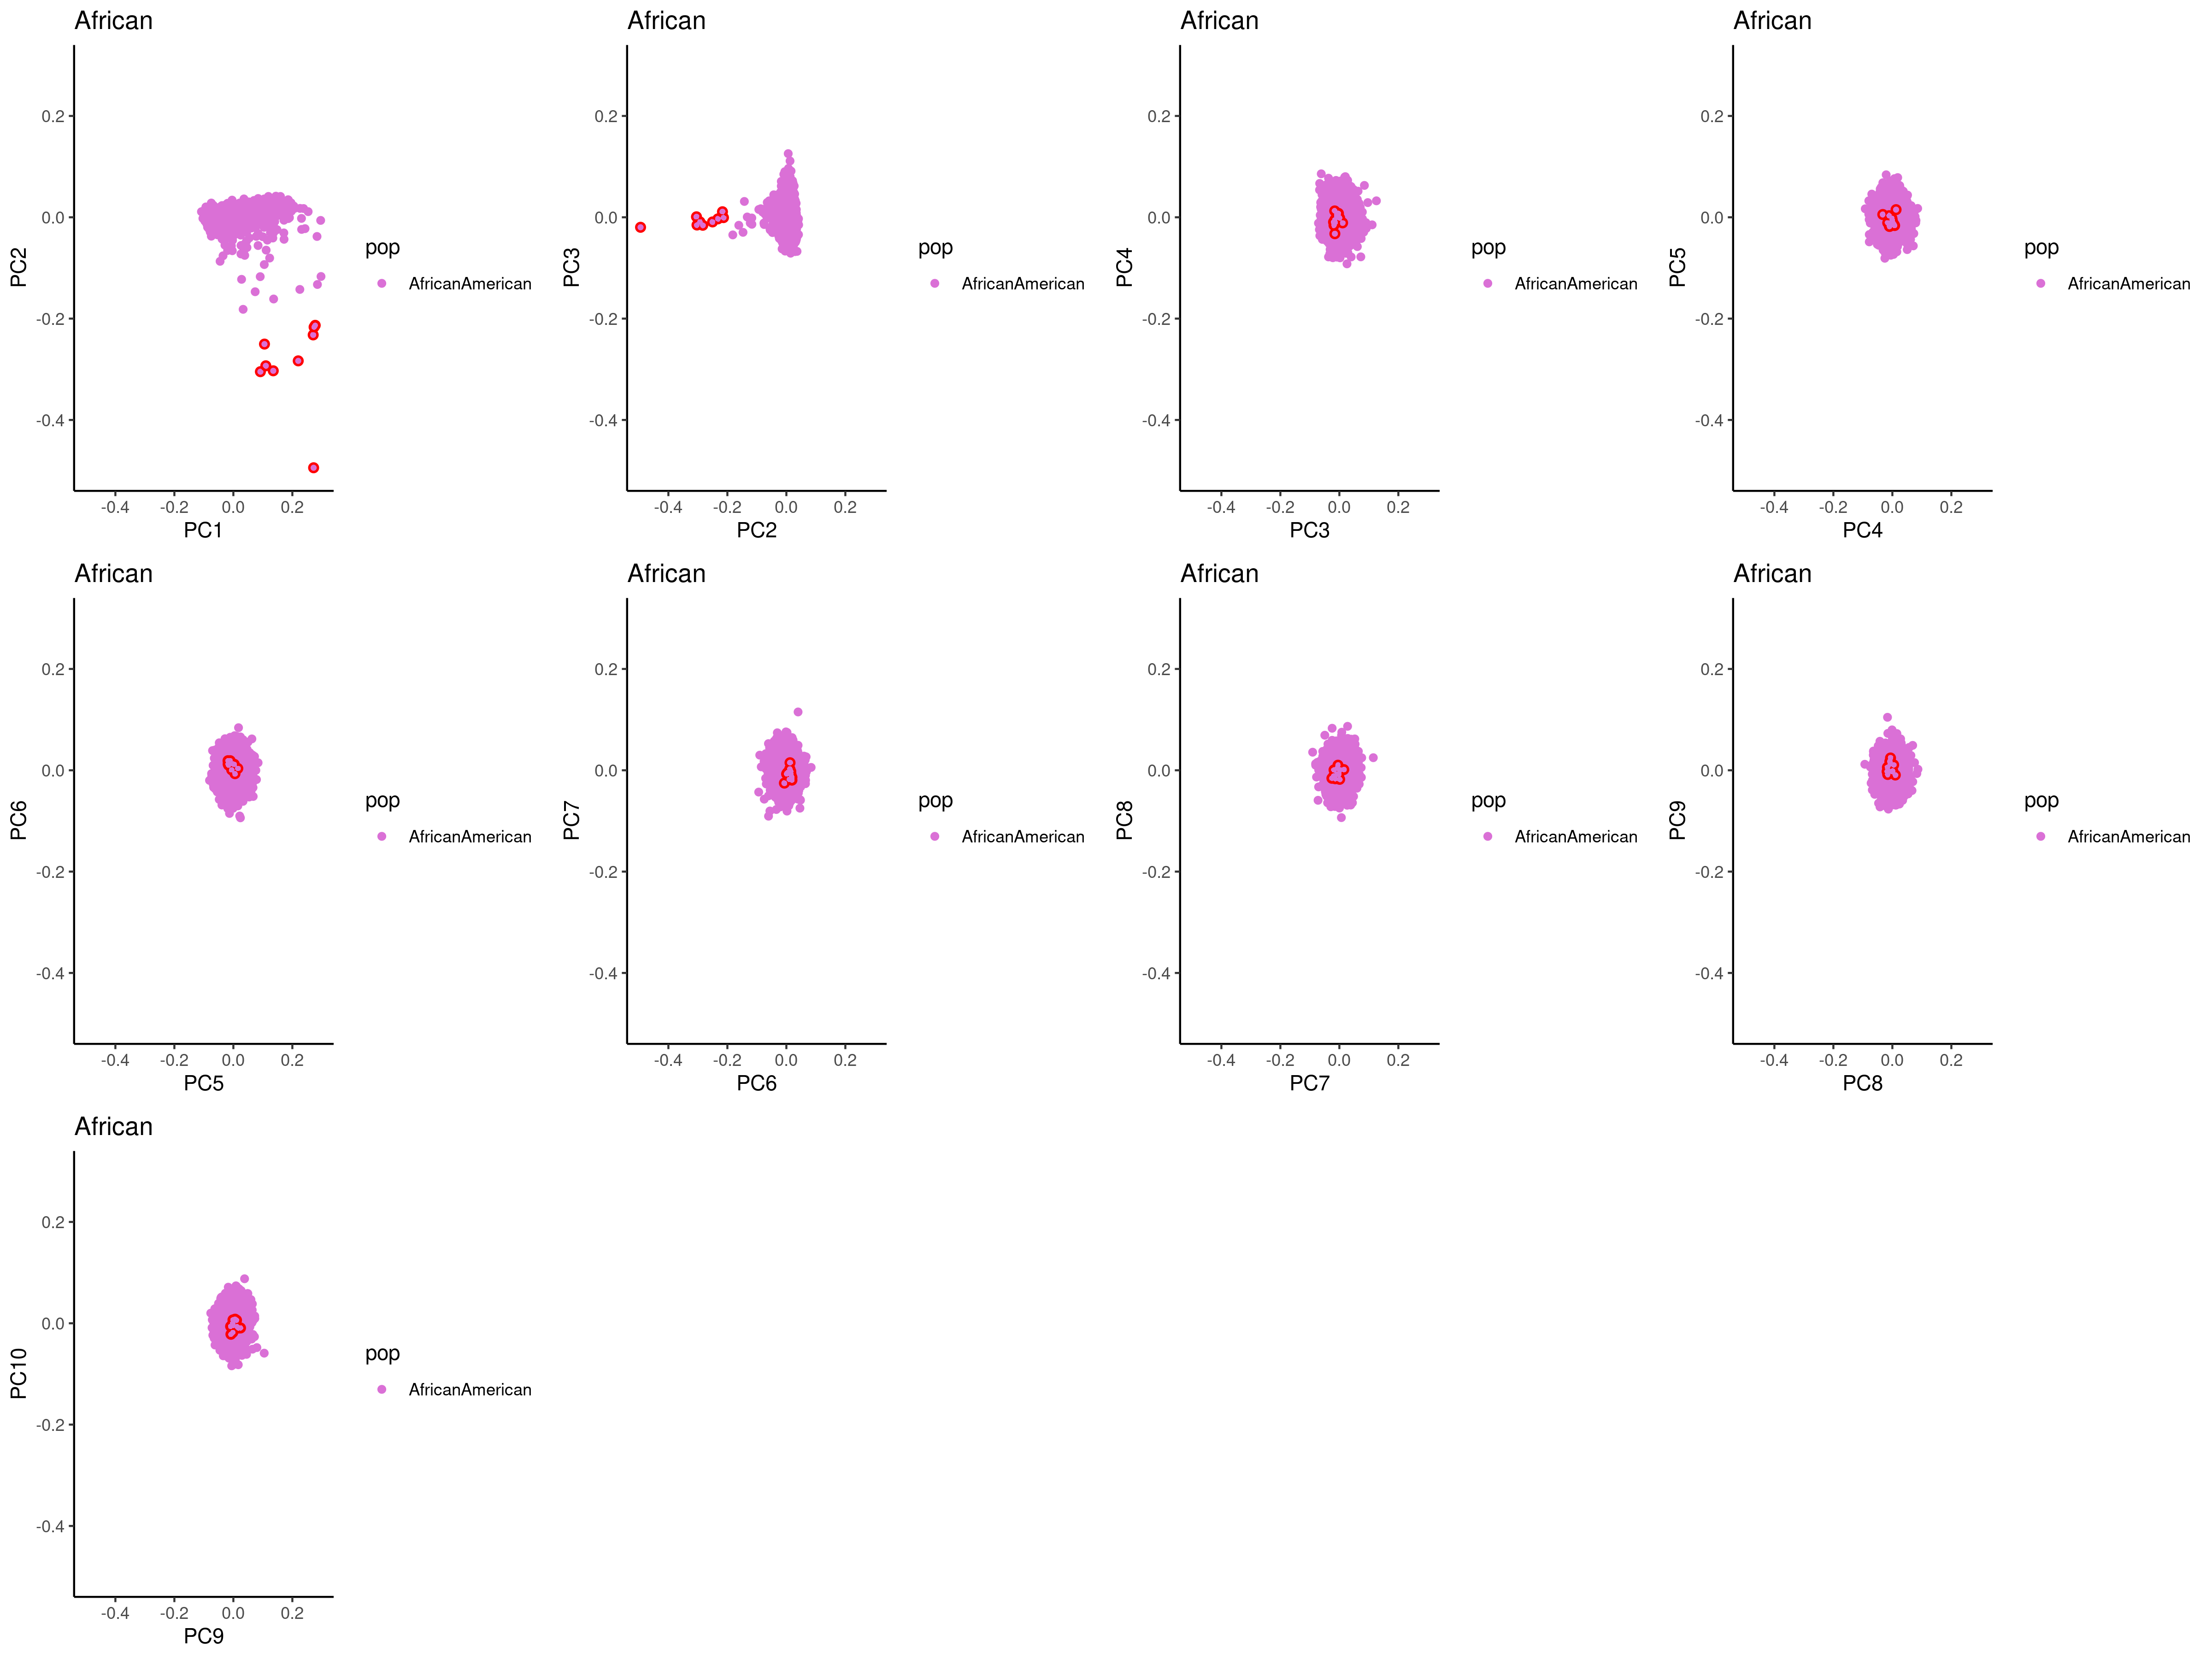

In [55]:
%preview /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/African.pca.projected.pc.png

> /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/European.pca.projected.pc.png (374.1 KiB):

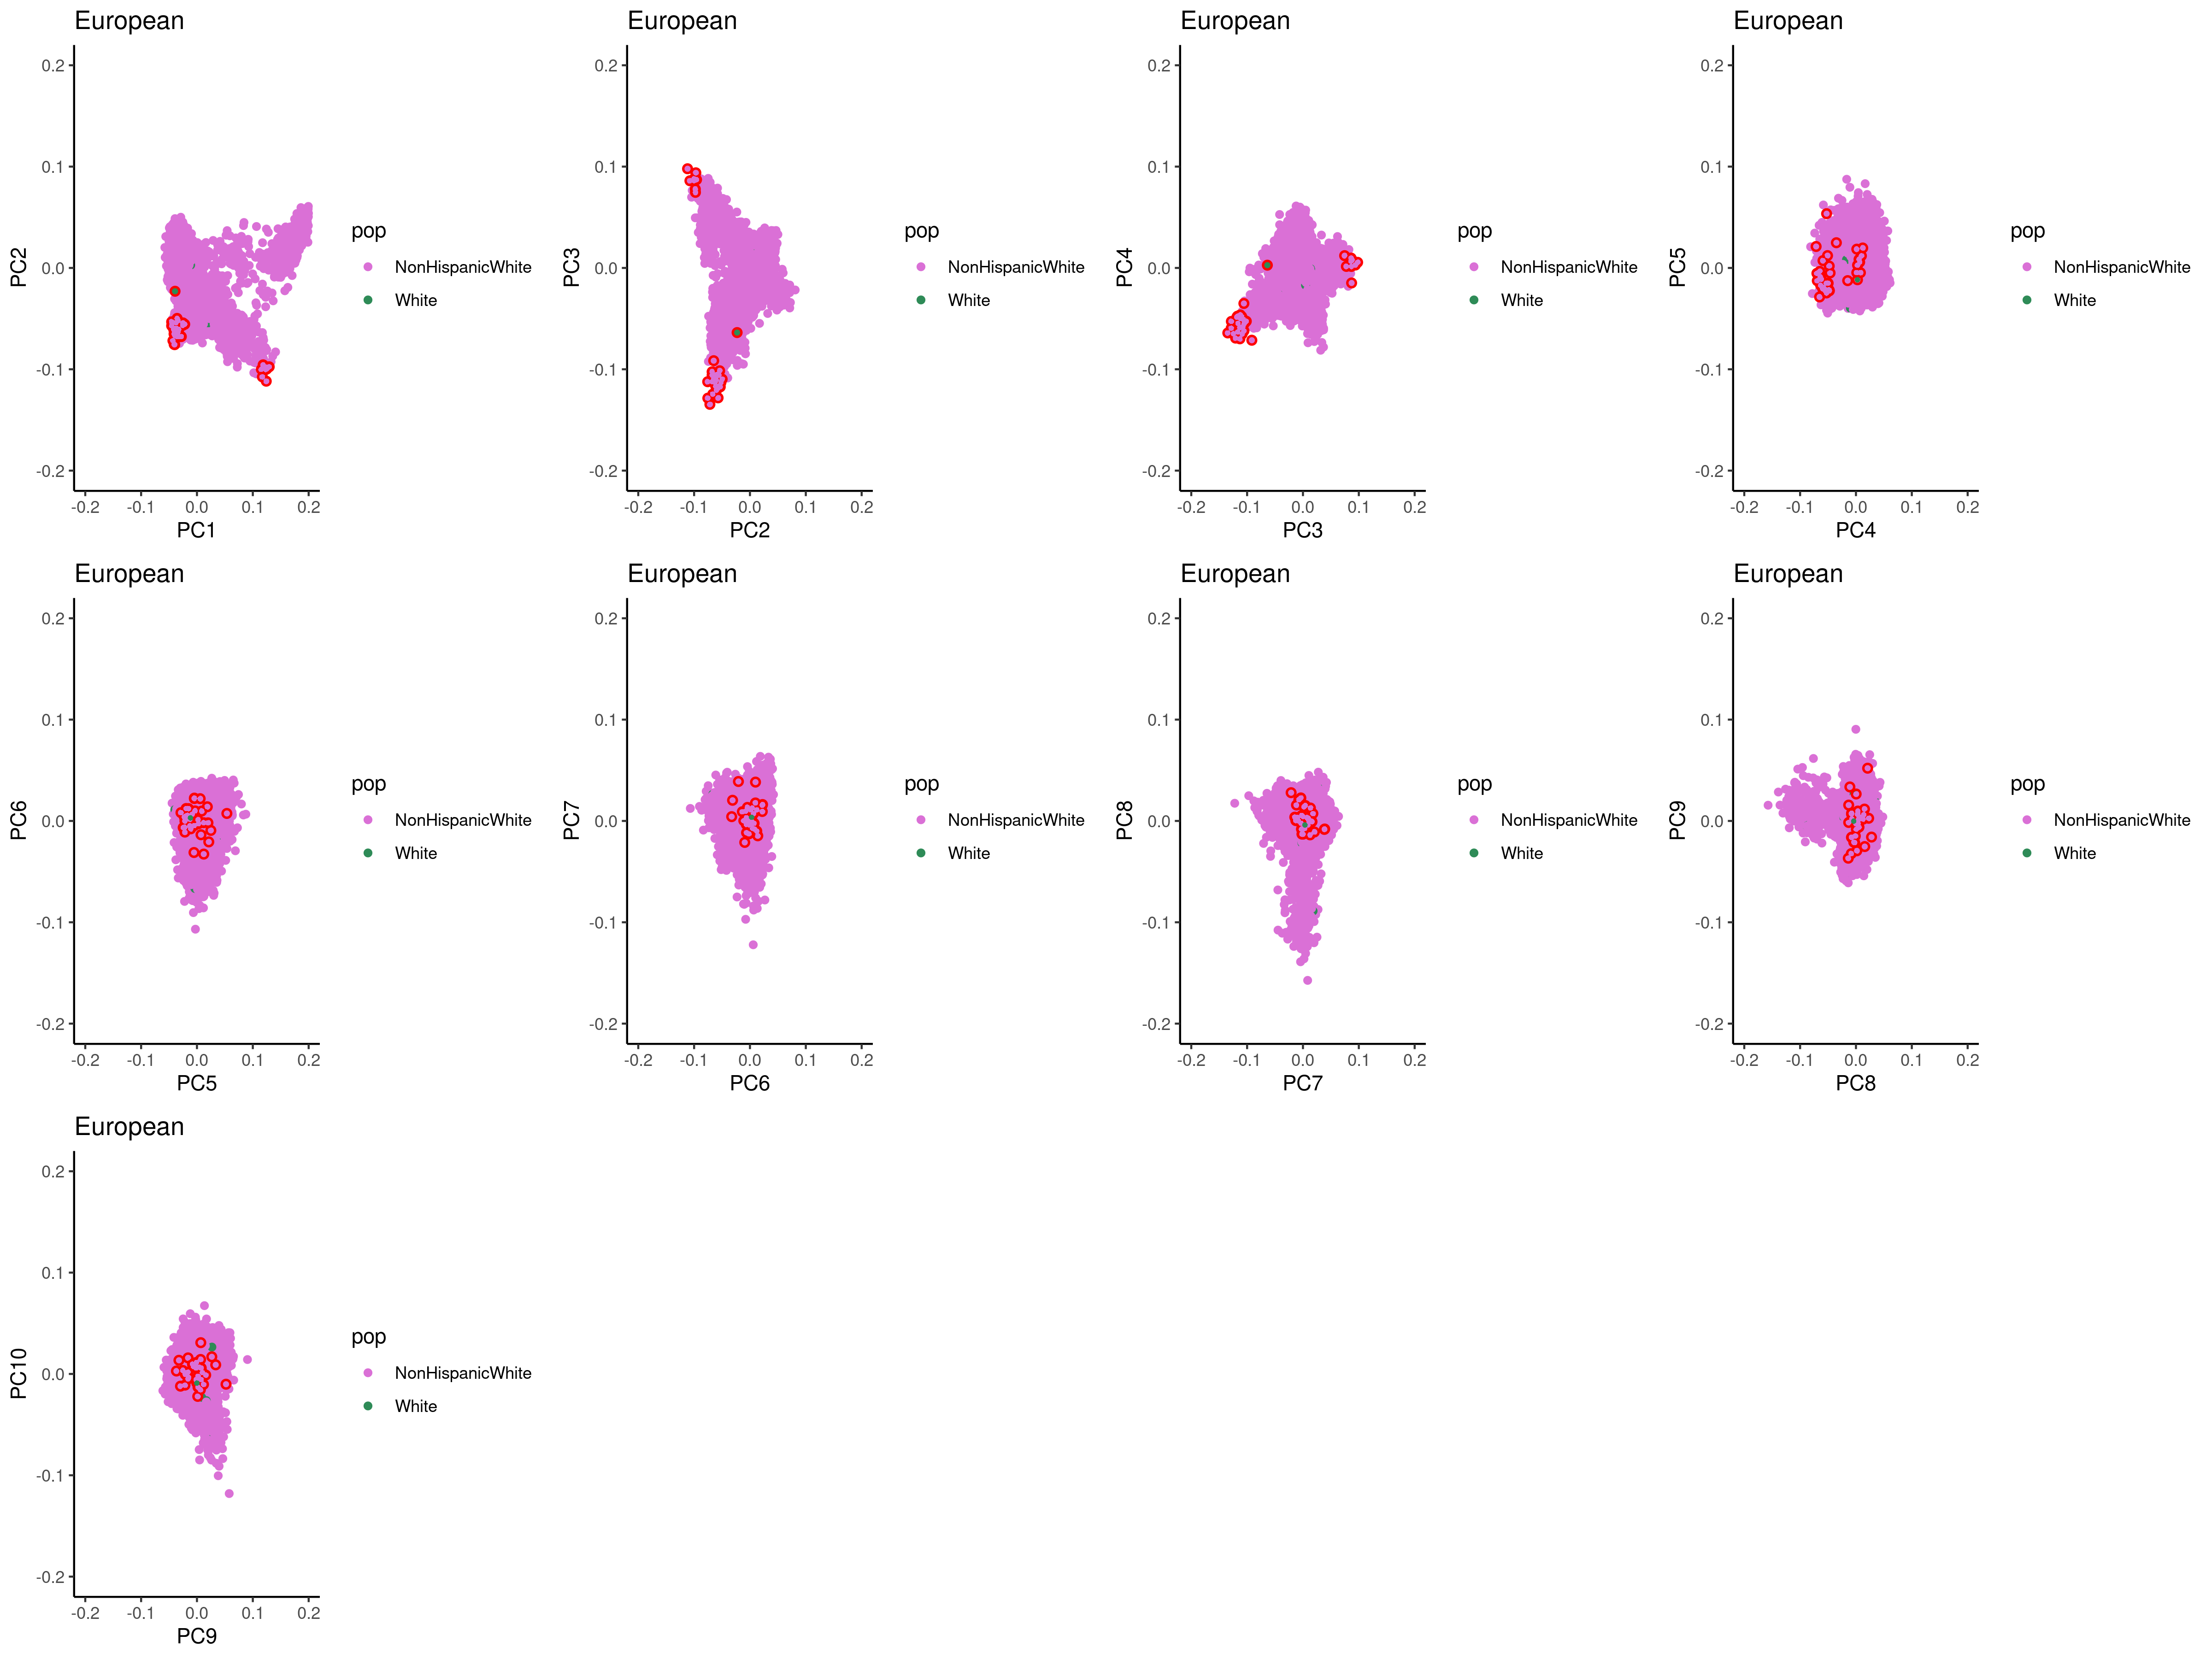

In [56]:
%preview /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/European.pca.projected.pc.png

> /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/Hispanic.pca.projected.pc.png (256.5 KiB):

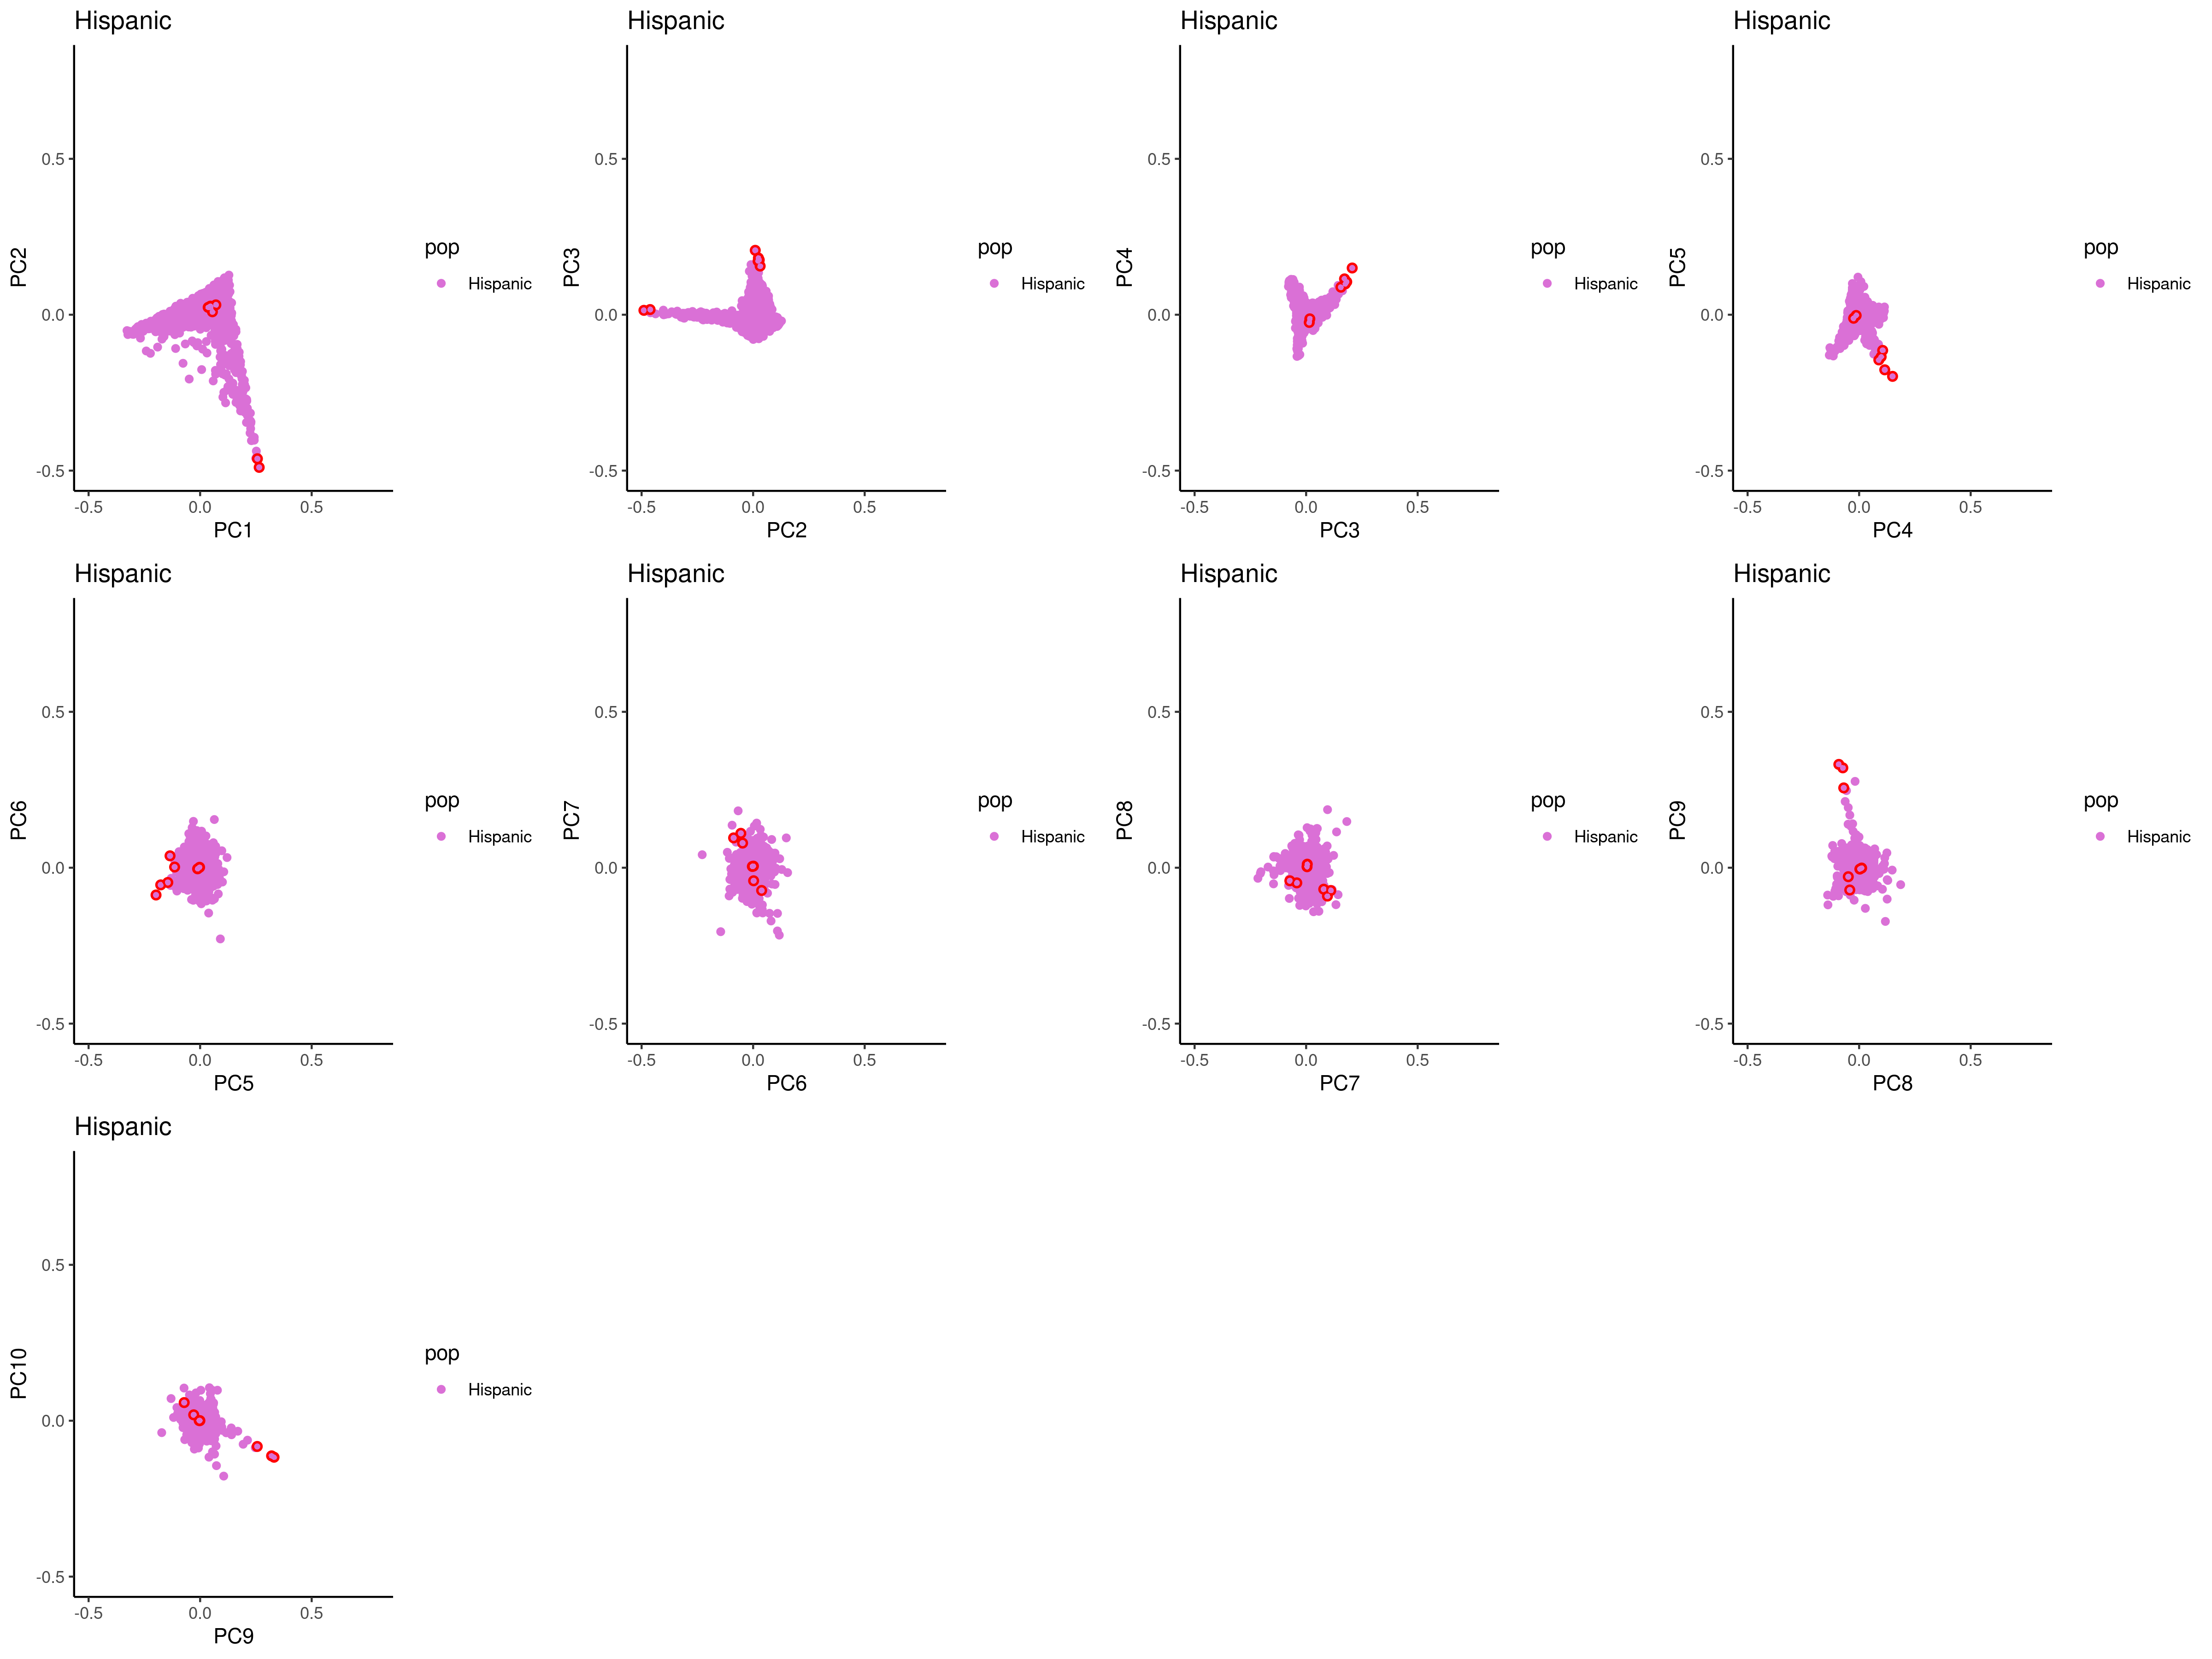

In [57]:
%preview /mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/Hispanic.pca.projected.pc.png

In [5]:
#need to exclude outliers from pca file in order to use it later in the null model built process.
pca_afr = read.table('/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/African.pca.projected.txt', header = T)
outlier_afr=read.table('/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/African.pca.projected.outliers', header = F)
pca_new_afr=pca_afr[is.na(match(pca_afr$IID,outlier_afr$V1)),]
pca_new_afr$AD=  recode(pca_new_afr$AD, `0` = 1, `1` = 2, `-9` = NULL)
write.table(pca_new_afr, '/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/African.pca.projected_outlier_removed.txt',sep='\t', col.names=T, row.names=F, quote=F)

pca_eur = read.table('/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/European.pca.projected.txt', header = T)
outlier_eur= read.table('/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/European.pca.projected.outliers', header = F)
pca_new_eur= pca_eur[is.na(match(pca_eur$IID,outlier_eur$V1)),]
pca_new_eur$AD=  recode(pca_new_eur$AD, `0` = 1, `1` = 2, `-9` = NULL)
write.table(pca_new_eur, '/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/European.pca.projected_outlier_removed.txt',sep='\t', col.names=T, row.names=F, quote=F)

pca_his = read.table('/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/Hispanic.pca.projected.txt', header = T)
outlier_his=read.table('/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/Hispanic.pca.projected.outliers', header = F)
pca_new_his=pca_his[is.na(match(pca_his$IID,outlier_his$V1)),]
pca_new_his$AD=  recode(pca_new_his$AD, `0` = 1, `1` = 2, `-9` = NULL)
write.table(pca_new_his, '/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/Hispanic.pca.projected_outlier_removed.txt',sep='\t', col.names=T, row.names=F, quote=F)


## Descriptive statistics for the samples included in the final analyses

In [1]:
#Final phenotypes.
AA <- read.table('/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/African.pca.projected_outlier_removed.txt', header = T)
EUR <- read.table('/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/European.pca.projected_outlier_removed.txt', header = T)
HIS <- read.table('/mnt/mfs/statgen/alzheimers-family/ADSP_2023/PCA_QC/Hispanic.pca.projected_outlier_removed.txt', header = T)

In [8]:
AA$APOE <- as.factor(AA$APOE)
AA$AD <- as.factor(AA$AD)
AA$Sex <- as.factor(AA$Sex)
EUR$APOE <- as.factor(EUR$APOE)
EUR$AD <- as.factor(EUR$AD)
EUR$Sex <- as.factor(EUR$Sex)
HIS$APOE <- as.factor(HIS$APOE)
HIS$AD <- as.factor(HIS$AD)
HIS$Sex <- as.factor(HIS$Sex)

In [4]:
library(tableone)

In [9]:
tableone_AA <- cbind(print(CreateTableOne(data = AA[,c("AD","Age","Sex","APOE")])),print(CreateTableOne(strata = "AD",data = AA[,c("Age","AD","Sex","APOE")])))
write.csv(tableone_AA,"AA_tableone.csv")
tableone_EUR <- cbind(print(CreateTableOne(data = EUR[,c("AD","Age","Sex","APOE")])),print(CreateTableOne(strata = "AD", data = EUR[,c("Age","AD","Sex","APOE")])))
write.csv(tableone_EUR,"EUR_tableone.csv")
tableone_HIS <- cbind(print(CreateTableOne(data = HIS[,c("AD","Age","Sex","APOE")])),print(CreateTableOne(strata = "AD", data = HIS[,c("Age","AD","Sex","APOE")])))
write.csv(tableone_HIS,"HIS_tableone.csv")

                 
                  Overall      
  n                3824        
  AD = 2 (%)       1392 (36.4) 
  Age (mean (SD)) 75.81 (8.38) 
  Sex = 1 (%)      2735 (71.5) 
  APOE (%)                     
     0             2102 (55.0) 
     1             1462 (38.2) 
     2              260 ( 6.8) 
                 Stratified by AD
                  1             2              p      test
  n                2432          1392                     
  Age (mean (SD)) 75.76 (8.27)  75.89 (8.57)    0.652     
  AD = 2 (%)          0 ( 0.0)   1392 (100.0)  <0.001     
  Sex = 1 (%)      1749 (71.9)    986 ( 70.8)   0.499     
  APOE (%)                                     <0.001     
     0             1560 (64.1)    542 ( 38.9)             
     1              803 (33.0)    659 ( 47.3)             
     2               69 ( 2.8)    191 ( 13.7)             
                 
                  Overall      
  n               11014        
  AD = 2 (%)       5776 (52.4) 
  Age (mean (SD